# Comparación clasificadores

En este Notebook aprenderemos a:

1. Determinar los parámetros libres óptimos de un clasificador (Alguien puede decirme que es un parametro optimo?)
2. Medir las prestaciones de un clasificador (revisar Evaluation Metrics.ipynb)
    - Accuracy
    - Confusion Matrix
3. Comparar clasificadores

Para ello, vamos a utilizar un ejemplo real con objeto de predecir el llamado *Apgar index*.

https://en.wikipedia.org/wiki/Apgar_score


### Base de datos para clasificación

El *Apgar index* se utiliza en la práctica clínica para evaluar el estado general del recién nacido después del parto. Este índice varía entre 0 y 10, de tal forma que es habitual hacer la siguiente división: 

* Si Apgar $\geq$ 7 se considera una situación normal, 
* Si Apgar $<$ 7 situación anormal o sospechosa. 

El problema que queremos resolver es el siguiente: predecir el índice Apgar utilizando diferentes parámetros de la señal de la [frecuencia cardiaca fetal](https://es.wikipedia.org/wiki/Frecuencia_card%C3%ADaca_fetal), *fetal heart rate* (FHR) en inglés. El FHR es una señal que se adquiere de forma rutinaria durante el trabajo de parto, por lo que sería muy útil si fuésemos capaces de predecir a partir de esta señal cuál va a ser el índice Apgar, lo que permitiría tomar medidas rápidas, o incluso adelantar el parto.

Vamos a plantear este problema desde el punto de vista de clasificación, de forma que los recien nacidos pueden pertenecer a una de las dos siguientes clases: **Normal**, $y = 0$, si Apgar $\geq$ 7; y **anormal** $y = 1$, si Apgar < 7. Normalmente siempre se asigna la clase $y = 1$ al evento que queremos detectar.

Las variables explicativas, características o *features* serán los parámetros estimados a partir del FHR, en concreto serán:

* Duration:	Duration in minutes of the FHR tracing
* Baseline:	Basal value of the FHR in beat/min
* Acelnum:	Number of FHR accelerations
* Acelrate:	Number of FHR accelerations per minute
* ASTV:	Percentage of the total duration with abnormal short term variability
* MSTV:	Average duration of the time intervals with abnormal short term variability
* ALTV:	Percentage of the total duration with abnormal long term variability
* MLTV:	Average duration of the time intervals with abnormal long term variability
    
La fuente de esta base de datos es *Dr. Diogo Ayres-de-Campos, Fac. Med. Univ. Porto*

In [37]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
%matplotlib inline

In [38]:
# cargamos fichero y hacemos una copia
data = pd.read_csv('./FHR-Apgar.csv',sep=';')

Nsamples,Nfeatures = data.shape

print ('# muestras = %d' %Nsamples, '; # features = %d'%Nfeatures)

# hacemos copia
fhrApgar = data.copy()
fhrApgar.head()

# muestras = 240 ; # features = 12


,HOSPITAL,NAME,Apgar 1,Apgar 5,Duration,Baseline,Acelnum,Acelrate,ASTV,MSTV,ALTV,MLTV
0,HUC,PMGVG,9.0,10.0,44.0,127.0,3.0,0.07,72.0,0.4,16.0,9.6
1,HUC,MCSR,8.0,10.0,55.0,126.0,23.0,0.42,59.0,1.1,0.0,10.8
2,HUC,SMCM,9.0,10.0,46.0,135.0,9.0,0.20,67.0,0.7,1.0,10.6
3,HUC,MFMBN,9.0,10.0,54.0,131.0,25.0,0.46,66.0,0.9,0.0,8.7
4,HUC,EMSO,9.0,10.0,47.0,142.0,12.0,0.26,61.0,0.8,10.0,7.6


In [39]:
# preprocesamos los datos:

# 1) Eliminarmos valores NaN
fhrApgar = fhrApgar.dropna()

# 2) variable target: y (Apgar 1), transformar en binaria
fhrApgar['Apgar'] = np.where(fhrApgar['Apgar 1'] >= 7,0,1)

# 3) Eliminamos columnas HOSPITAL, NAME, Apgar 1, Apgar 5
fhrApgar = fhrApgar.drop(['HOSPITAL', 'NAME', 'Apgar 1', 'Apgar 5'],axis=1)

Nsamples,Nfeatures = fhrApgar.shape
print ('# muestras = %d' %Nsamples, '; # features = %d'%Nfeatures)

fhrApgar.head()

# muestras = 223 ; # features = 9


,Duration,Baseline,Acelnum,Acelrate,ASTV,MSTV,ALTV,MLTV,Apgar
0,44.0,127.0,3.0,0.07,72.0,0.4,16.0,9.6,0
1,55.0,126.0,23.0,0.42,59.0,1.1,0.0,10.8,0
2,46.0,135.0,9.0,0.20,67.0,0.7,1.0,10.6,0
3,54.0,131.0,25.0,0.46,66.0,0.9,0.0,8.7,0
4,47.0,142.0,12.0,0.26,61.0,0.8,10.0,7.6,0


In [40]:
# Echamos un vistazo a los datos
fhrApgar.describe()

,Duration,Baseline,Acelnum,Acelrate,ASTV,MSTV,ALTV,MLTV,Apgar
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,45.116592,130.511211,12.403587,0.275785,48.650224,1.151121,8.730942,10.329596,0.134529
std,8.851876,9.223873,8.291882,0.172661,13.008438,0.944394,13.705700,3.599477,0.341988
min,30.000000,110.000000,0.000000,0.000000,25.000000,0.300000,0.000000,1.900000,0.000000
25%,40.000000,125.000000,7.000000,0.155000,39.000000,0.700000,0.000000,8.100000,0.000000
50%,44.000000,130.000000,12.000000,0.270000,46.000000,1.000000,4.000000,9.900000,0.000000
75%,51.500000,136.000000,18.000000,0.390000,58.500000,1.300000,11.000000,11.800000,0.000000
max,60.000000,171.000000,47.000000,0.780000,88.000000,11.900000,95.000000,23.500000,1.000000


A fast way to get an idea of the distribution of each attribute is to look at histograms. Histograms
group data into bins and provide you a count of the number of observations in each bin. From
the shape of the bins you can quickly get a feeling for whether an attribute is Gaussian, skewed
or even has an exponential distribution. It can also help you see possible outliers.

### Review Visualization.ipynb

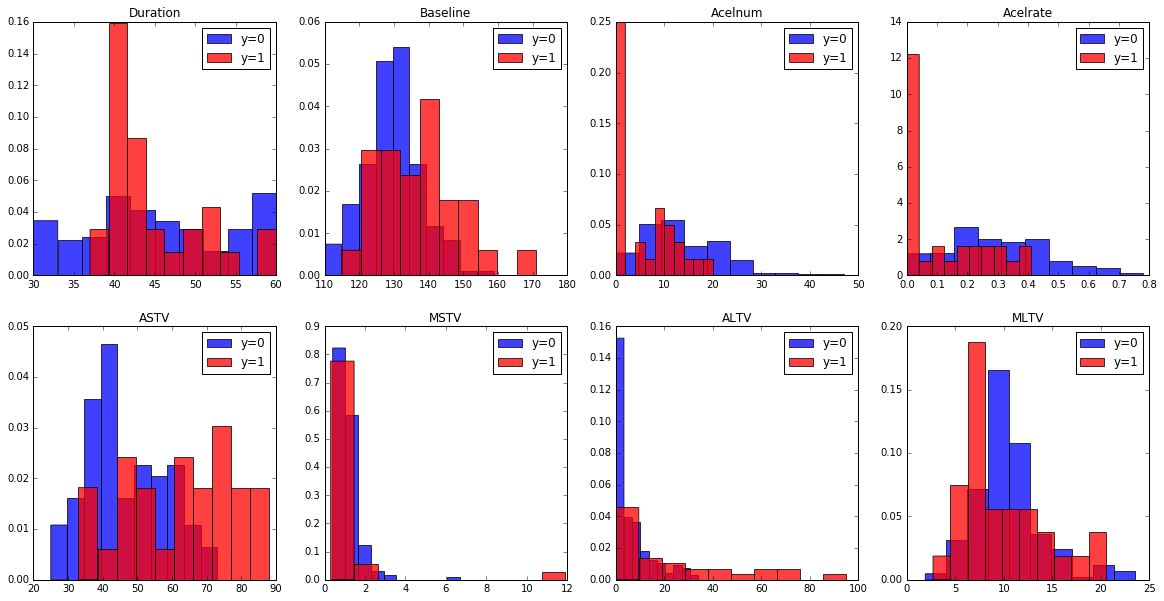

In [11]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,10))

idx_0 =  fhrApgar['Apgar'] == 0
idx_1 =  fhrApgar['Apgar'] == 1

for i,feature in enumerate(fhrApgar.columns.drop(['Apgar'])):
    plt.subplot(2,4,i+1)   
    plt.hist(fhrApgar.ix[idx_0,feature],normed=1, alpha=0.75,label='y=0')
    plt.hist(fhrApgar.ix[idx_1,feature],normed=1, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

In [12]:
#TRUCO
# Podemos hacer transformaciones sobre las variables, para que el histograma se parezca más a una gaussiana
fhrApgar['Duration'] = fhrApgar['Duration']*fhrApgar['Duration']
fhrApgar['MSTV']     = fhrApgar['MSTV'].apply(lambda x: np.log10(x))
fhrApgar['ALTV']     = fhrApgar['ALTV'].apply(lambda x: np.sqrt(x))
fhrApgar['Acelnum']  = fhrApgar['Acelnum'].apply(lambda x: np.sqrt(x))
fhrApgar['Acelrate'] = fhrApgar['Acelrate'].apply(lambda x: np.sqrt(x))

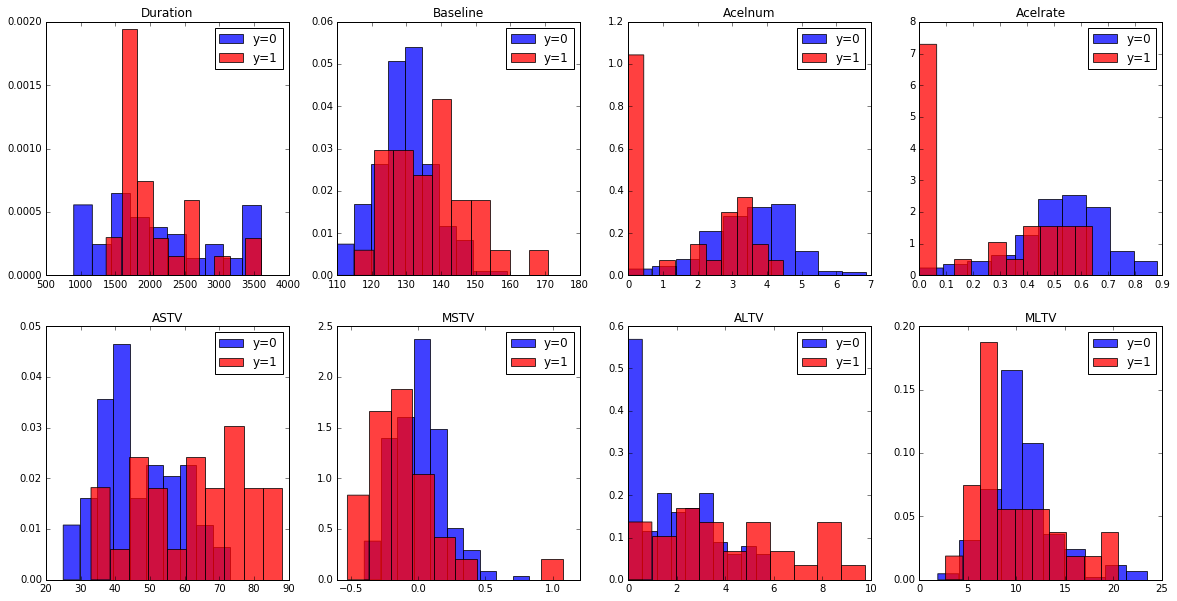

In [13]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,10))

idx_0 =  fhrApgar['Apgar'] == 0
idx_1 =  fhrApgar['Apgar'] == 1

for i,feature in enumerate(fhrApgar.columns.drop(['Apgar'])):
    plt.subplot(2,4,i+1)   
    plt.hist(fhrApgar.ix[idx_0,feature],normed=1, alpha=0.75,label='y=0')
    plt.hist(fhrApgar.ix[idx_1,feature],normed=1, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

### REVISAR Evaluation Methods.ipynb

In [16]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# convertimos el DataFrame al formato necesario para scikit-learn
data4scikit = fhrApgar.as_matrix() 

y = data4scikit[:,-1]      # nos quedamos con la última columna, Apgar
X = data4scikit[:,0:-1]    # nos quedamos con el resto

feature_names = fhrApgar.columns[0:-1]

# Dividimos los datos en entrenamiento y test (70 training, 30 test)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.35, random_state = 2,stratify=y)

print ('Datos entrenamiento: ', Xtrain.shape)
print ('Datos test: ', Xtest.shape)

perc_clase_1_train = 100.0*(ytrain==1).sum() / len(ytrain)
perc_clase_1_test  = 100.0*(ytest==1).sum() / len(ytest)

print ('Porcentaje Clase(y=1), train: %0.4g' %perc_clase_1_train)
print ('Porcentaje Clase(y=1), test : %0.4g' %perc_clase_1_test)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(Xtrain)
XtrainScaled = scaler.transform(Xtrain)
XtestScaled = scaler.transform(Xtest)

Datos entrenamiento:  (144, 8)
Datos test:  (79, 8)
Porcentaje Clase(y=1), train: 13.19
Porcentaje Clase(y=1), test : 13.92


## Medida de prestaciones

Como podemos comprobar, el porcentaje de muestras asociadas a la clase $y=1$ es sólo de un 13%, lo que significa que se trata de un problema de clasificación [desbalanceado](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning.pdf), es decir, que hay un mayor porcentaje de muestras de una clase que de la otra. 

Cuando trabajamos con problemas desbalanceados tenemos que ser cuidadosos a la hora de diseñar nuestro clasificador, puesto que la métrica de *accuracy* (revisar Evaluation Metrics.ipynb )puede no ser indicativa de sus prestaciones reales. Por ejemplo, para nuestro problema podríamos diseñar un clasificador que predijera todas las muestras como clase $y=0$, y en ese caso nuestro error sólo sería del 13%, es decir, que tendríamos una accuracy del 87%. 

Por tanto, al medir las prestaciones de un clasificador bajo un problema desbalanceado conviene utilizar métricas que nos indiquen cómo hemos acertado en las dos clases. Para ello, utilizamos la denominada [**matriz de confusión**](https://en.wikipedia.org/wiki/Confusion_matrix). Esta matriz recoge el número de muestras correcta e incorrectamente clasificadas para cada clase. Las filas representan las etiquetas verdaderas y las columnas las etiquetas predichas. 

<img src="./figs/Binary_confusion_matrix.png"> Fuente: [Wikipedia](https://en.wikipedia.org/wiki/File:Binary_confusion_matrix.png)

Esta matriz recoge las siguientes medidas:

* TP (True Positive): número de casos para las que se predice $y=1$ (Apgar < 7), cuando la etiqueta real era $y=1$
* TN (True Negative): número de casos para las que se predice $y=0$ (Apgar $\geq$ 7), cuando la etiqueta real era $y=0$
* FN (False Negative): número de casos para los que se predice $y=0$ (Apgar $\geq$ 7), cuando la etiqueta real era $y=1$.
* FP (False Positive): número de casos para los que se predice $y=1$ (Apgar < 7), cuando la etiqueta real era $y=10$. También se conoce como Falsa Alarma.


Con estas cuatro medidas, se pueden calcular las siguientes métricas:

* Sensibilidad (Se): porcentaje de muestras etiquetadas como Apgar < 7 correctamente clasificadas.

$$\textrm{S}_e= \frac{\textrm{TP}}{\textrm{TP} + \textrm{FN}}$$

* Especificidad (Sp): porcentaje de muestras etiquetadas como Apgar $\geq$ 7 correctamente clasificadas

$$\textrm{S}_p = \frac{\textrm{TN}}{\textrm{TN} + \textrm{FP}}$$

* BER (Balanced Error Rate), o tasa de error balanceado:

$$\textrm{BER} = 1- \frac{1}{2}\left(\textrm{S}_e + \textrm{S}_p \right)$$

* ACC (Accuracy)

$$\textrm{Acc} = \frac{\textrm{TP} + \textrm{TN}}{\textrm{TP} + \textrm{FN} + \textrm{TN} + \textrm{FP}}$$

La BER es una buena medida a tener en cuenta en problemas desbalanceados, ya que supone un compromiso entre sensibilidad y especificidad. El mejor caso, BER = 0, mientras que el peor sería BER = 0.5.

Scikit-learn tiene implementadas unas cuantas [medidas de prestaciones](http://scikit-learn.org/stable/modules/model_evaluation.html) para evaluar las prestaciones de un clasificador, pero con fines ilustrativos utilizaremos sólo las arriba mencionadas.

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.scorer import make_scorer

def give_metrics(y_true,y_pred):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
      
    print ('Matriz de confusión: \n', confusion_matrix(y_true, y_pred))
    
    sn = 1.0* tp / (tp + fn)
    sp = 1.0* tn / (tn + fp)
    ber = 1 - 0.5*(sn + sp)
    acc = 1.0*(tp+tn) / (tp + tn + fp + fn)
    
    print( '\nMétricas:')
    print ('SEN\tESP\tBER\tACC')
    print ('%0.2f ' %sn, '\t%0.2f ' %sp, '\t%0.2f ' %ber, '\t%0.2f ' %acc)

def my_score_func(y_true,y_pred):  
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sn = 1.0* tp / (tp + fn)
    sp = 1.0* tn / (tn + fp)
    ber = 1 - 0.5*(sn + sp)
    return ber

my_scorer = make_scorer(my_score_func, greater_is_better=True)

## Comparación de algoritmos

### Regresión logística

Comencemos con el algoritmo de regresión logística, para el valor de coste $C$ por defecto:

In [22]:
from sklearn.linear_model import LogisticRegression
#####TRUCO########
lr = LogisticRegression(class_weight='balanced') # ponemos class_weight='balanced' para aliviar desbalanceo
lr.fit(XtrainScaled,ytrain)
ypred = lr.predict(XtestScaled)
give_metrics(ytest,ypred)

Matriz de confusión: 
 [[62  6]
 [ 6  5]]

Métricas:
SEN	ESP	BER	ACC
0.45  	0.91  	0.32  	0.85 


Tiene un parametro de control de complejidad, conocido como C, basicamente el error cuadratico medio (MSE) lo querias minimizar y añades un termino extra para penalizar ciertos pesos. Puede ser una penalizacion de orden 2 o de orden 1.

Revisemos Ridge y Lasso para regresion lineal.

En el caso de RL el coste multiplica al MSE, en vez de aplicar a los pesos de los coeficientes como en la regresion lineal. 


Vamos a buscar el valor óptimo de $C$, mediante cross-validation. Para ello, utilizaremos la función [*GridSearchCV*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de scikit-learn.

[  1.00000000e-05   3.72759372e-05   1.38949549e-04   5.17947468e-04
   1.93069773e-03   7.19685673e-03   2.68269580e-02   1.00000000e-01
   3.72759372e-01   1.38949549e+00   5.17947468e+00   1.93069773e+01
   7.19685673e+01   2.68269580e+02   1.00000000e+03]


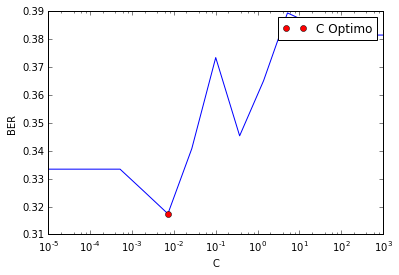

In [42]:
from sklearn.model_selection import GridSearchCV

# Buscamos el valor de C óptimo según conjunto de entrenamiento
Cvector = np.logspace(-5,3,15)
print(Cvector)
tuned_parameters = {'C': Cvector}
grid = GridSearchCV(lr, param_grid=tuned_parameters, scoring = my_scorer,cv=3) #3-fold cross-validatio
grid.fit(XtrainScaled, ytrain)

scores = np.array(grid.cv_results_['mean_test_score'])
idx = np.argmin(scores)
Copt = Cvector[idx]

plt.semilogx(Cvector,scores)
plt.semilogx(Cvector[idx],scores[idx],'ro',label='C Optimo')
plt.xlabel('C')
plt.ylabel('BER')
plt.legend()
plt.show()

In [68]:
print("Copt",Copt)
lr = LogisticRegression(class_weight='balanced', C = Copt)
lr.fit(XtrainScaled,ytrain)
ypred = lr.predict(XtestScaled)
give_metrics(ytest,ypred)

Copt 0.00719685673001
Matriz de confusión: 
 [[55 13]
 [ 4  7]]

Métricas:
SEN	ESP	BER	ACC
0.64  	0.81  	0.28  	0.78 


Hemos disminuido la BER. El mejor caso, BER = 0, mientras que el peor sería BER = 0.5.


### K-nn 

Recordad que la clave es coger el numero de vecinos y hay que claibrarlo usando GridSearchCV cross-validation

/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the f

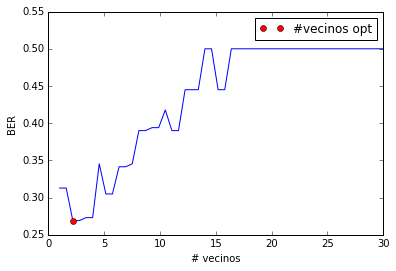

n_opt 2.18367346939
Matriz de confusión: 
 [[68  0]
 [ 8  3]]

Métricas:
SEN	ESP	BER	ACC
0.27  	1.00  	0.36  	0.90 


/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/usr/local/pr/ipython/lib/python3.3/site-packages/sklearn/externals/joblib/parallel.py:131: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the f

In [67]:
from sklearn.neighbors import KNeighborsClassifier

# grid search
n_neighbors = np.linspace(1.0,30)
tuned_parameters = {'n_neighbors': n_neighbors}

knnModelCV = KNeighborsClassifier()
grid = GridSearchCV(knnModelCV, param_grid=tuned_parameters, scoring = my_scorer,cv=3) #3-fold cross-validatio
grid.fit(XtrainScaled, ytrain)

scores = np.array(grid.cv_results_['mean_test_score'])
idx    = np.argmin(scores)
n_opt  = n_neighbors[idx]

plt.plot(n_neighbors,scores)
plt.plot(n_neighbors[idx],scores[idx],'ro',label='#vecinos opt')
plt.xlabel('# vecinos')
plt.ylabel('BER')
plt.legend()
plt.show()
print("n_opt",n_opt)
# Evaluamos en test
knnModel =KNeighborsClassifier(n_neighbors=n_opt)
knnModel.fit(XtrainScaled,ytrain)
ypred = knnModel.predict(XtestScaled)
give_metrics(ytest,ypred)

In [51]:
?np.linspace

### Árboles de decisión

#### Máxima profundidad de árbol. Controla el número máximo de niveles de crecimiento por debajo del nodo raíz

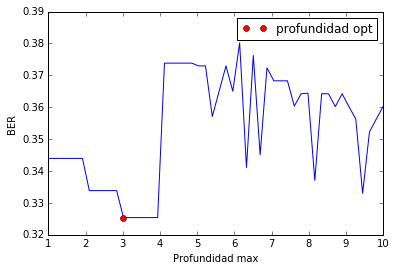

depth_opt 3.02040816327
Matriz de confusión: 
 [[62  6]
 [ 5  6]]

Métricas:
SEN	ESP	BER	ACC
0.55  	0.91  	0.27  	0.86 


In [63]:
from sklearn import tree

# grid search
max_depth = np.linspace(1.0,10)
tuned_parameters = {'max_depth': max_depth}

treeModelCV = tree.DecisionTreeClassifier(class_weight='balanced')
grid = GridSearchCV(treeModelCV, param_grid=tuned_parameters, scoring = my_scorer,cv=3) #5-fold cross-validatio
grid.fit(XtrainScaled, ytrain)

scores = np.array(grid.cv_results_['mean_test_score'])
idx    = np.argmin(scores)
depth_opt  = max_depth[idx]

plt.plot(max_depth,scores)
plt.plot(max_depth[idx],scores[idx],'ro',label='profundidad opt')
plt.xlabel('Profundidad max')
plt.ylabel('BER')
plt.legend()
plt.show()
print("depth_opt",depth_opt)
# Evaluamos en test
treeModel = tree.DecisionTreeClassifier(class_weight='balanced',max_depth = depth_opt)
treeModel.fit(XtrainScaled,ytrain)
ypred = treeModel.predict(XtestScaled)
give_metrics(ytest,ypred)

#### Random Forest

Vamos a probar ahora un tipo de algoritmo basado en árboles, llamado [*random forest*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

Random forest es un método que combina una cantidad grande de árboles de decisión independientes probados sobre conjuntos de datos aleatorios con igual distribución.

La fase de aprendizaje consiste en crear muchos árboles de decisión independientes, construyéndolos a partir de datos de entrada ligeramente distintos. Se altera, por tanto, el conjunto inicial de partida, haciendo lo siguiente:

– Se selecciona aleatoriamente con reemplazamiento un porcentaje de datos de la muestra total.

Es habitual incluir un segundo nivel aleatoriedad, esta vez afectando los atributos:

– En cada nodo, al seleccionar la partición óptima, tenemos en cuenta sólo una porción de los atributos, elegidos al azar en cada ocasión.

Una vez que tenemos muchos árboles, 1000 por ejemplo, la fase de clasificación se lleva a cabo de la siguiente forma:

– Cada árbol se evalúa de forma independiente y la predicción del bosque será la media de los 1000 árboles. La proporción de árboles que toman una misma respuesta se interpreta como la probabilidad de la misma.

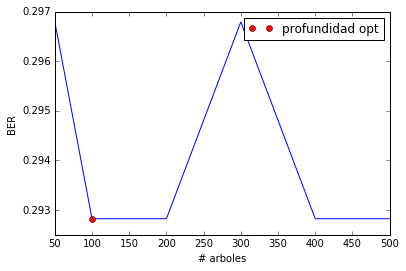

Matriz de confusión: 
 [[66  2]
 [ 7  4]]

Métricas:
SEN	ESP	BER	ACC
0.36  	0.97  	0.33  	0.89 


In [56]:
from sklearn.ensemble import RandomForestClassifier

# grid search
n_estimators= [50,100,200,300,400,500]# cuantos arboles?
tuned_parameters = {'n_estimators': n_estimators}

rfModelCV = RandomForestClassifier(max_depth=None,class_weight='balanced')

grid = GridSearchCV(rfModelCV, param_grid=tuned_parameters, scoring = my_scorer,cv=3) #5-fold cross-validatio
grid.fit(XtrainScaled, ytrain)

scores = np.array(grid.cv_results_['mean_test_score'])
idx    = np.argmin(scores)
n_est_opt  = n_estimators[idx]

plt.plot(n_estimators,scores)
plt.plot(n_estimators[idx],scores[idx],'ro',label='profundidad opt')
plt.xlabel('# arboles')
plt.ylabel('BER')
plt.legend()
plt.show()

# Evaluamos en test
rfModel = RandomForestClassifier(n_estimators=n_est_opt,max_depth=None,class_weight='balanced')
rfModel.fit(XtrainScaled,ytrain)
ypred = rfModel.predict(XtestScaled)
give_metrics(ytest,ypred)

In [33]:
### SVMs

In [54]:
from sklearn import svm

# grid search
Cvector = np.logspace(-2,2,30)
gammaVector = np.logspace(-3,2,30)
tuned_parameters = {'gamma': gammaVector,'C': Cvector}

svmModelCV= svm.SVC(kernel='rbf',class_weight= {1:3})
grid = GridSearchCV(svmModelCV, param_grid=tuned_parameters, scoring = my_scorer,cv=3) #5-fold cross-validatio
grid.fit(XtrainScaled, ytrain)

c_opt = Cvector[idx_c]
g_opt = gammaVector[idx_g]

print ('C: %0.3g' %c_opt, 'gamma: %0.3g' %g_opt )

# Evaluamos en test
svmModel= svm.SVC(kernel='rbf',  C = c_opt, gamma =  g_opt)
svmModel.fit(XtrainScaled,ytrain)
ypred = svmModel.predict(XtestScaled)
give_metrics(ytest,ypred)

C: 0.329 gamma: 0.0356
Matriz de confusión: 
 [[68  0]
 [11  0]]

Métricas:
SEN	ESP	BER	ACC
0.00  	1.00  	0.50  	0.86 
